In [1]:
!conda install -c conda-forge -y matplotlib 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/rf27/miniconda3/envs/New_awesome_environment

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       h7f98852_5          17 KB  conda-forge
    brotli-bin-1.0.9           |       h7f98852_5          19 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    kiwisolver-1.3.1           |   py39h2531618_0          80 KB
    libbrotlicommon-1.0.9      |       h7f98852_5          65 KB  conda-forge
    libbrotlidec-1.0.9         |       h7f98852_5          33 KB  conda-forge
    libbrotlienc-1.0.9         |       h7f98852_5   

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

import torch

from sklearn.preprocessing import OneHotEncoder

from torch_geometric import data as DATA
from torch_geometric.data import Data, DataLoader

from torch import optim, nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [3]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [4]:
test_edges = pd.read_csv("./Test Dataset/test_edges.csv", header=0)
test_labels = pd.read_csv("./Test Dataset/test_labels.csv", header=0)
ground_truth = np.array(test_labels).flatten()

In [5]:
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().sigmoid().numpy()

In [6]:
edge_folds = pd.read_csv("./data_split.csv", header=0)
edge_folds = edge_folds[edge_folds['Label'] == 1]
edge_folds.loc[edge_folds['Fold'] == 'Test', 'Fold'] = 5
edge_folds.loc[edge_folds['Fold'] == '3', 'Fold'] = 3
edge_folds.loc[edge_folds['Fold'] == '4', 'Fold'] = 4

/home/rf27/miniconda3/envs/New_awesome_environment/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# MLP first

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.fc1 = nn.Linear(in_channels * 2, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.fc3 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        return x

    def decode(self, z, edge_label_index):
        x = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

# Text type features
features = pd.read_csv("./DOC2Vec_features.csv")
features = features.sort_values(by=['id'])

# Page type features
page_type = pd.read_csv("./Training/node_classification.csv")
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(page_type['page_type'].to_numpy().reshape(-1, 1))

page_type = pd.concat([page_type.drop('page_type', 1),
            pd.DataFrame(myEncoder.transform(page_type['page_type'].to_numpy().reshape(-1, 1)))], 
                         axis=1).reindex()

# Node Id Embedding features
embedding = torch.nn.Embedding(page_type.shape[0], 32)
embedding = pd.DataFrame(np.array(embedding.weight.data))
embedding['id'] = range(page_type.shape[0])

# Finalize Feature Embedding
features = features.merge(page_type, how='inner', on='id').merge(embedding, how='inner', on='id')
features = features.drop(columns=['id'])

features = torch.Tensor(features.to_numpy()).to(device)

total_fold_predictions = {}
total_fold_truths = {}
for r in range(1, 6):
    
    edge_folds_train = edge_folds[edge_folds['Fold'] != r]
    G = nx.from_pandas_edgelist(edge_folds_train, 'Node1', 'Node2')

    edge_index = []
    for e1, e2 in G.edges:
        edge_index.append([e1, e2])
    
    edge_label_index_test = list(test_edges.to_records(index=False))
    
    test_graph = DATA.Data(
        x = features.to(device),
        edge_index = torch.LongTensor(edge_index).transpose(1, 0).to(device),
        edge_label_index = torch.LongTensor(edge_label_index_test).transpose(1, 0).to(device),
        edge_label = torch.LongTensor(test_labels['label'].to_numpy())
    )
    
    model = Net(164, 128, 64).to(device)
    model_path = "./models/MLP_DOC2Vec_fold" + str(r) + ".pt"
    model.load_state_dict(torch.load(model_path))

    total_fold_predictions[r] = test(test_graph)

In [8]:
MLP_predictions = (total_fold_predictions[1] + \
                   total_fold_predictions[2] + \
                   total_fold_predictions[3] + \
                   total_fold_predictions[4] + \
                   total_fold_predictions[5])/5

In [9]:
fpr_MLP, tpr_MLP, _ = roc_curve(ground_truth, MLP_predictions)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)

# GCN DOC2Vec

In [10]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        
        self.fc1 = nn.Linear(out_channels * 2, out_channels)
        self.fc2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)

    def decode(self, z, edge_label_index):
        x = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Text type features
features = pd.read_csv("./DOC2Vec_features.csv")
features = features.sort_values(by=['id'])

# PCA ONLY on TF_IDF

# Page type features
page_type = pd.read_csv("./Training/node_classification.csv")
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(page_type['page_type'].to_numpy().reshape(-1, 1))

page_type = pd.concat([page_type.drop('page_type', 1),
            pd.DataFrame(myEncoder.transform(page_type['page_type'].to_numpy().reshape(-1, 1)))], 
                         axis=1).reindex()

# Node Id Embedding features
embedding = torch.nn.Embedding(page_type.shape[0], 32)
embedding = pd.DataFrame(np.array(embedding.weight.data))
embedding['id'] = range(page_type.shape[0])

# Finalize Feature Embedding
features = features.merge(page_type, how='inner', on='id').merge(embedding, how='inner', on='id')
features = features.drop(columns=['id'])

features = torch.Tensor(features.to_numpy()).to(device)

total_fold_predictions = {}
total_fold_truths = {}
for r in range(1, 6):
    
    edge_folds_train = edge_folds[edge_folds['Fold'] != r]
    G = nx.from_pandas_edgelist(edge_folds_train, 'Node1', 'Node2')

    edge_index = []
    for e1, e2 in G.edges:
        edge_index.append([e1, e2])
    
    edge_label_index_test = list(test_edges.to_records(index=False))
    
    test_graph = DATA.Data(
        x = features.to(device),
        edge_index = torch.LongTensor(edge_index).transpose(1, 0).to(device),
        edge_label_index = torch.LongTensor(edge_label_index_test).transpose(1, 0).to(device),
        edge_label = torch.LongTensor(test_labels['label'].to_numpy())
    )
    
    model = Net(164, 128, 64).to(device)
    model_path = "./models/GCN_doc2vec_fold" + str(r) + ".pt"
    model.load_state_dict(torch.load(model_path))

    total_fold_predictions[r] = test(test_graph)

In [11]:
GCNDOC2vec_predictions = (total_fold_predictions[1] + \
                           total_fold_predictions[2] + \
                           total_fold_predictions[3] + \
                           total_fold_predictions[4] + \
                           total_fold_predictions[5])/5

In [12]:
fpr_GCNDOC2Vec, tpr_GCNDOC2Vec, _ = roc_curve(ground_truth, GCNDOC2vec_predictions)
roc_auc_GCNDOC2Vec = auc(fpr_GCNDOC2Vec, tpr_GCNDOC2Vec)

In [13]:
roc_auc_GCNDOC2Vec

0.8533908995996494

# GCNGlove

In [14]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        
        self.fc1 = nn.Linear(out_channels * 2, out_channels)
        self.fc2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)

    def decode(self, z, edge_label_index):
        x = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Text type features
features = pd.read_csv("./GLoVE_features.csv")
features = features.sort_values(by=['id'])

# PCA ONLY on TF_IDF

# Page type features
page_type = pd.read_csv("./Training/node_classification.csv")
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(page_type['page_type'].to_numpy().reshape(-1, 1))

page_type = pd.concat([page_type.drop('page_type', 1),
            pd.DataFrame(myEncoder.transform(page_type['page_type'].to_numpy().reshape(-1, 1)))], 
                         axis=1).reindex()

# Node Id Embedding features
embedding = torch.nn.Embedding(page_type.shape[0], 32)
embedding = pd.DataFrame(np.array(embedding.weight.data))
embedding['id'] = range(page_type.shape[0])

# Finalize Feature Embedding
features = features.merge(page_type, how='inner', on='id').merge(embedding, how='inner', on='id')
features = features.drop(columns=['id'])

features = torch.Tensor(features.to_numpy()).to(device)

total_fold_predictions = {}
total_fold_truths = {}
for r in range(1, 6):
    
    edge_folds_train = edge_folds[edge_folds['Fold'] != r]
    G = nx.from_pandas_edgelist(edge_folds_train, 'Node1', 'Node2')

    edge_index = []
    for e1, e2 in G.edges:
        edge_index.append([e1, e2])
    
    edge_label_index_test = list(test_edges.to_records(index=False))
    
    test_graph = DATA.Data(
        x = features.to(device),
        edge_index = torch.LongTensor(edge_index).transpose(1, 0).to(device),
        edge_label_index = torch.LongTensor(edge_label_index_test).transpose(1, 0).to(device),
        edge_label = torch.LongTensor(test_labels['label'].to_numpy())
    )
    
    model = Net(164, 128, 64).to(device)
    model_path = "./models/GCN_Glove_fold" + str(r) + ".pt"
    model.load_state_dict(torch.load(model_path))

    total_fold_predictions[r] = test(test_graph)

In [15]:
GCNGlove_predictions = (total_fold_predictions[1] + \
                        total_fold_predictions[2] + \
                        total_fold_predictions[3] + \
                        total_fold_predictions[4] + \
                        total_fold_predictions[5])/5

In [16]:
fpr_GCNGlove, tpr_GCNGlove, _ = roc_curve(ground_truth, GCNGlove_predictions)
roc_auc_GCNGlove = auc(fpr_GCNGlove, tpr_GCNGlove)

In [17]:
roc_auc_GCNGlove

0.8881564585409318

# GCN using nothing

In [18]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        
        self.fc1 = nn.Linear(out_channels * 2, out_channels)
        self.fc2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)

    def decode(self, z, edge_label_index):
        x = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Text type features
#features = pd.read_csv("./GLoVE_features.csv")
features = pd.DataFrame(data={'id': range(edge_folds.shape[0])})
features = features.sort_values(by=['id'])

# PCA ONLY on TF_IDF

# Page type features
page_type = pd.read_csv("./Training/node_classification.csv")
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(page_type['page_type'].to_numpy().reshape(-1, 1))

page_type = pd.concat([page_type.drop('page_type', 1),
            pd.DataFrame(myEncoder.transform(page_type['page_type'].to_numpy().reshape(-1, 1)))], 
                         axis=1).reindex()

# Node Id Embedding features
embedding = torch.nn.Embedding(page_type.shape[0], 32)
embedding = pd.DataFrame(np.array(embedding.weight.data))
embedding['id'] = range(page_type.shape[0])

# Finalize Feature Embedding
features = features.merge(page_type, how='inner', on='id').merge(embedding, how='inner', on='id')
features = features.drop(columns=['id'])

features = torch.Tensor(features.to_numpy()).to(device)

total_fold_predictions = {}
total_fold_truths = {}
for r in range(1, 6):
    
    edge_folds_train = edge_folds[edge_folds['Fold'] != r]
    G = nx.from_pandas_edgelist(edge_folds_train, 'Node1', 'Node2')

    edge_index = []
    for e1, e2 in G.edges:
        edge_index.append([e1, e2])
    
    edge_label_index_test = list(test_edges.to_records(index=False))
    
    test_graph = DATA.Data(
        x = features.to(device),
        edge_index = torch.LongTensor(edge_index).transpose(1, 0).to(device),
        edge_label_index = torch.LongTensor(edge_label_index_test).transpose(1, 0).to(device),
        edge_label = torch.LongTensor(test_labels['label'].to_numpy())
    )
    
    model = Net(36, 128, 64).to(device)
    model_path = "./models/GCN_PageType_fold" + str(r) + ".pt"
    model.load_state_dict(torch.load(model_path))

    total_fold_predictions[r] = test(test_graph)

In [19]:
GCNTypes_predictions = (total_fold_predictions[1] + \
                        total_fold_predictions[2] + \
                        total_fold_predictions[3] + \
                        total_fold_predictions[4] + \
                        total_fold_predictions[5])/5

In [20]:
fpr_GCNTypes, tpr_GCNTypes, _ = roc_curve(ground_truth, GCNTypes_predictions)
roc_auc_GCNTypes = auc(fpr_GCNTypes, tpr_GCNTypes)

In [21]:
roc_auc_GCNTypes

0.8145183764366202

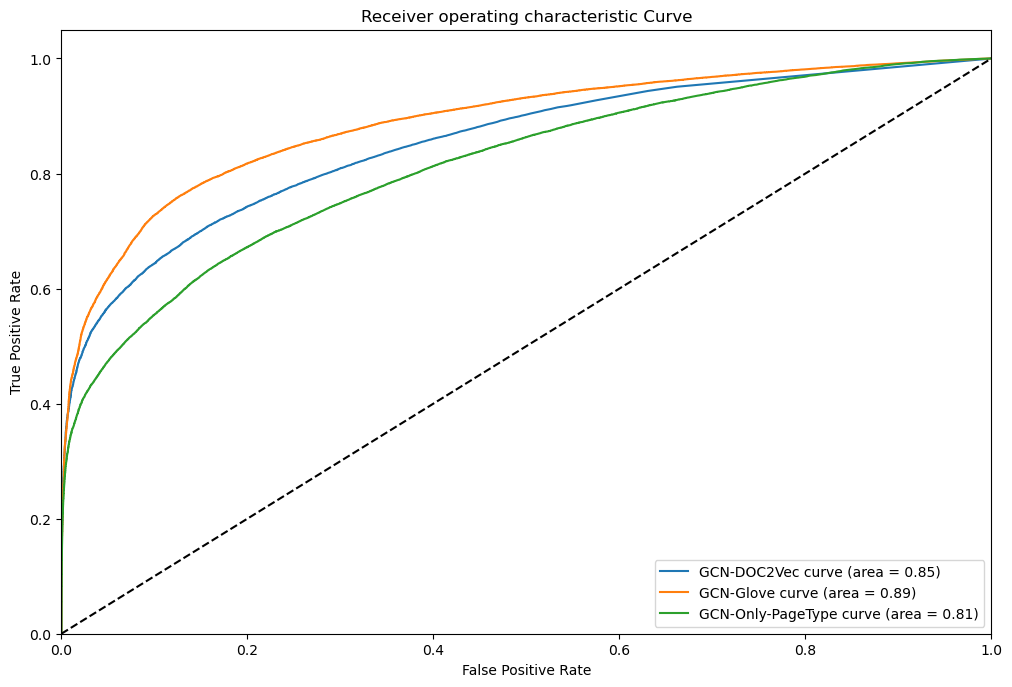

In [28]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(12,8), dpi= 100)
plt.plot(fpr_GCNDOC2Vec, tpr_GCNDOC2Vec, label='GCN-DOC2Vec curve (area = %0.2f)' % roc_auc_GCNDOC2Vec)
plt.plot(fpr_GCNGlove, tpr_GCNGlove, label='GCN-Glove curve (area = %0.2f)' % roc_auc_GCNGlove)
plt.plot(fpr_GCNTypes, tpr_GCNTypes, label='GCN-Only-PageType curve (area = %0.2f)' % roc_auc_GCNTypes)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Last GAT

In [33]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GATConv(in_channels, 2 * hidden_channels, heads=2, dropout=0.6)

        self.conv2 = GATConv(4 * hidden_channels, hidden_channels, heads=1, concat=False,
                             dropout=0.6)
        
        self.conv3 = GATConv(hidden_channels, out_channels, heads=1, concat=False,
                             dropout=0.6)
        
        self.fc1 = nn.Linear(out_channels * 2, out_channels)
        self.fc2 = nn.Linear(out_channels, 1)

    def encode(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        return x
    
    def decode(self, z, edge_label_index):
        x = torch.cat((z[edge_label_index[0]], z[edge_label_index[1]]), 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x
    
# Text type features
features = pd.read_csv("./GLoVE_features.csv")
#features = pd.DataFrame(data={'id': range(edge_folds.shape[0])})
features = features.sort_values(by=['id'])

# PCA ONLY on TF_IDF

# Page type features
page_type = pd.read_csv("./Training/node_classification.csv")
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(page_type['page_type'].to_numpy().reshape(-1, 1))

page_type = pd.concat([page_type.drop('page_type', 1),
            pd.DataFrame(myEncoder.transform(page_type['page_type'].to_numpy().reshape(-1, 1)))], 
                         axis=1).reindex()

# Node Id Embedding features
embedding = torch.nn.Embedding(page_type.shape[0], 32)
embedding = pd.DataFrame(np.array(embedding.weight.data))
embedding['id'] = range(page_type.shape[0])

# Finalize Feature Embedding
features = features.merge(page_type, how='inner', on='id').merge(embedding, how='inner', on='id')
features = features.drop(columns=['id'])

features = torch.Tensor(features.to_numpy()).to(device)

total_fold_predictions = {}
total_fold_truths = {}
for r in range(1, 6):
    
    edge_folds_train = edge_folds[edge_folds['Fold'] != r]
    G = nx.from_pandas_edgelist(edge_folds_train, 'Node1', 'Node2')

    edge_index = []
    for e1, e2 in G.edges:
        edge_index.append([e1, e2])
    
    edge_label_index_test = list(test_edges.to_records(index=False))
    
    test_graph = DATA.Data(
        x = features.to(device),
        edge_index = torch.LongTensor(edge_index).transpose(1, 0).to(device),
        edge_label_index = torch.LongTensor(edge_label_index_test).transpose(1, 0).to(device),
        edge_label = torch.LongTensor(test_labels['label'].to_numpy())
    )
    
    model = Net(164, 128, 64).to(device)
    model_path = "./models/GAT_DOC2Vec_fold" + str(r) + ".pt"
    model.load_state_dict(torch.load(model_path))

    total_fold_predictions[r] = test(test_graph)    

In [34]:
GATDoc2Vec_predictions = (total_fold_predictions[1] + \
                          total_fold_predictions[2] + \
                          total_fold_predictions[3] + \
                          total_fold_predictions[4] + \
                          total_fold_predictions[5])/5

In [35]:
fpr_GAT, tpr_GAT, _ = roc_curve(ground_truth, GATDoc2Vec_predictions)
roc_auc_GAT = auc(fpr_GAT, tpr_GAT)

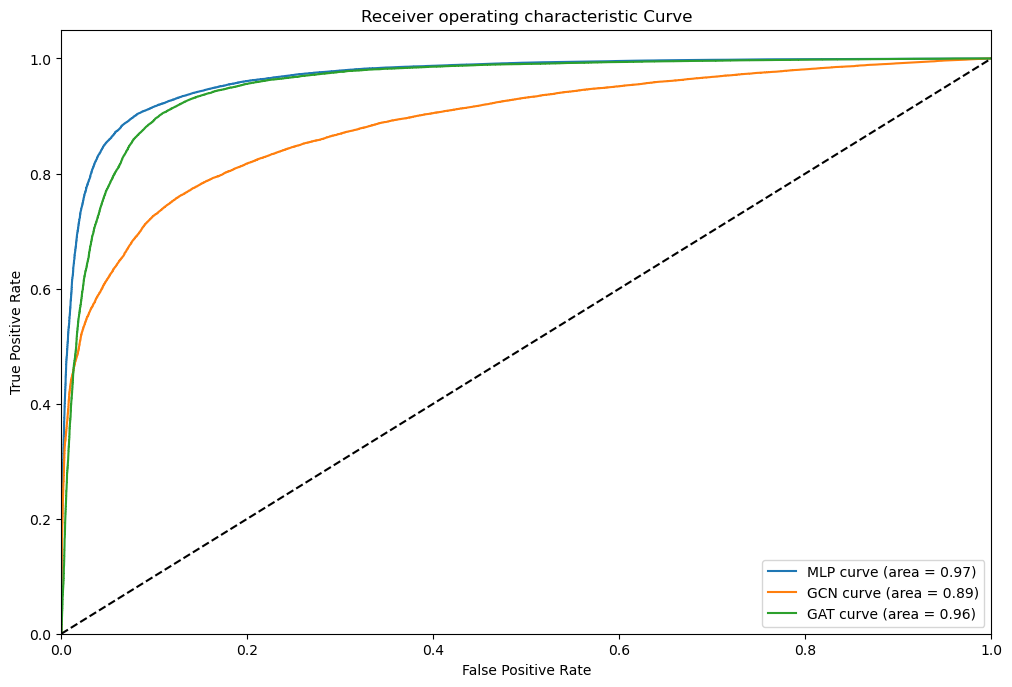

In [37]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(12,8), dpi= 100)
plt.plot(fpr_MLP, tpr_MLP, label='MLP curve (area = %0.2f)' % roc_auc_MLP)
plt.plot(fpr_GCNGlove, tpr_GCNGlove, label='GCN curve (area = %0.2f)' % roc_auc_GCNGlove)
plt.plot(fpr_GAT, tpr_GAT, label='GAT curve (area = %0.2f)' % roc_auc_GAT)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Curve')
plt.legend(loc="lower right")
plt.show()